<a href="https://colab.research.google.com/github/keymemory/Machine_Learning_Second/blob/main/ML2_day4_K_avg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 import
# pandas 라이브러리는 R에서 사용하는 Dataframe 같이 자료형을 정립시켜주는 
# 라이브러리 
# seaborn은 matplotlib에서 지원하지 않는 고급 통계 차트를 그리기 위한 
# 라이브러리 
# numpy는 선형대수 연산을 위한 라이브러리

import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# num_vertors는 점의 갯수
num_vectors = 100

# num_clusters는 k개의 군집합 k개
num_clusters = 4

# num_steps는 반복 학습할 횟수
num_steps = 100

# vector_values는 해당 점들이 들어갈 리스트로 for 문에 따라 점이 생성되어 
# 들어가게 된다.
vector_values = []

In [ ]:
# x가 평균 0.5에 표준편차 0.6을 따르고, y는 평균 0.3에 표준편차 0.9를 따르는 
# 좌표, 나머지 반은 x가 2.5평균에 표준편차 0.4를 따르고 y는 평균 0.8에 표준
# 편차 0.5를 따르는 좌표를 생성하여 vector_values에 넣는다.
for i in range(num_vectors):
  if np.random.random() > 0.5:
    vector_values.append([np.random.normal(0.5, 0.6),
                          np.random.normal(0.3, 0.9)])
  else:
    vector_values.append([np.random.normal(2.5, 0.4),
                         np.random.normal(0.8, 0.5)])
    
# x와 y값을 각각 세팅하여 데이터 프레임 설정
df = pd.DataFrame({"x": [v[0] for v in vector_values], 
                   "y": [v[1] for v in vector_values]})

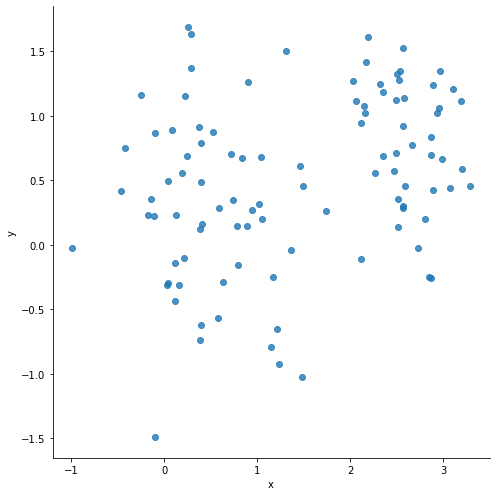

In [ ]:
# 데이터로 하여 seaborn 라이브러리의 그래프 그리는 함수로 넘기고 높이를 7로 
# 생성
sns.lmplot("x", "y", data=df, fit_reg=False, height=7)
plt.show()

In [ ]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution ()


In [ ]:
# 분류과정으로
# vectors라는 변수에 생성된 좌표들을 넣고 난 뒤에 centroids라는 변수에다가 넣
# 는다.
vectors = tf.constant(vector_values)

In [ ]:
# random_shuffle이라는 함수는 1차원을 기준으로 안에 있는 값을 섞어주는 역할을 
# 한다. 즉 vectors에 들어있는 좌표값은 무작위로 바뀌었으며, 0,0부터 해서 
# num_clusters 즉 4개의 값을 끝까지(인덱스가 -1이면 N까지이다) 추출하게 된다. # 그 값은 Centroids에 4,2 형태의 텐서 구조로 들어가게 된다.
# 두개 변수 내의 좌표 간 연산을 위하여 차원 확장을 해주어야 하는데 vectors의 # 경우에는 0차원 추가, centroids의 경우 1차원을 추가한다.
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], 
                          [num_clusters,-1]))
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

In [ ]:
print(expanded_vectors.get_shape())
print(expanded_centroids.get_shape())

(1, 100, 2)
(4, 1, 2)


In [ ]:
# subtract 메소드를 이용하여 expanded_vectors와 expanded_centroids의 원소들간
# 을 빼는데, 이는 거리를 구하기 위함이다. 서로 구조가 다른데 어떻게 그게 가능
# 하냐면 텐서플로우가 알아서 늘려서 계산해주기 때문이다. 그렇게 계산시 임의로 
# 뽑하낸 4점에 대해서 각각의 차를 계산하게 된다.
# 그런 다음에 각각의 뺀 값들을 제곱하여 각 거리들이 더욱 크게 부각되게 만들어# 준 뒤에 2차원에 위치한 그 값들을 각각 전부 더해 리스트화 하여 리턴한다.
# 그리고 argmin 값을 이용해서 각각 나뉜것들 중에서 가장 작은 값을 가진 인덱스
# 를 리턴한다.

In [ ]:
distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, 
             expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)

In [ ]:
# means 값을 centroids에 업데이트 시키고 해당 연산을 update_centroids에 할당
# 한다.
means = tf.concat([
  tf.reduce_mean(
      # gather는 c군집을 이루는 점들의 좌표를 모은 텐서 D0:1, D1:2000,D2:2를 
      # 제작하고 각 군집의 값들을 평균내어 means 텐서에 붙이면. means에는 1~4
      # 군집의 중심으로 값이 있는 means에 붙인다.
      tf.gather(vectors,
                # reshape는 D0: 1 D1: 2000의 형태로 바꿔준다. 
                tf.reshape(
                  # where은 각 군집에 해당하는 값 true로 표시된 값으로 가지는 
                  # 텐서를 만든다.
                  tf.where(
                    # equal은 assignments에서 c값에 맞는 값을 true로 전환하여 
                    # D0: 2000을 반환한다.
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1])
  for c in range(num_clusters)], 0)

update_centroids = tf.assign(centroids, means)

In [ ]:
# 모든 변수를 initializer를 통해서 초기화하고 세션을 생성해서 run을 한다.
init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

In [ ]:
# run을 하는데 num_steps수 만큼 반복한다. 매개 변수로 지정된 세개의 연산은 
# run 함수를 호출하는 순간 지정된 순서대로 실행되는데, 찾아야할 값이 세 개이
# 므로 세개의 연산에 상응하는 텐서 세개를 numpy 배열로 만들어 리턴한다.
# update_centroids 연산은 return값이 없으므로 언더바로 결과를 버리고 나머지 
# 값들은 각각 centroid_values, assignment_values를 넣는다.
for step in range(num_steps):
   _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments])

In [ ]:
print("centroids")
print(centroid_values)

centroids
[[ 0.20732152  0.7310164 ]
 [ 0.6566642  -0.31086817]
 [ 2.7739289   0.48917195]
 [ 2.2398198   1.1150774 ]]


In [ ]:
# 각각 군집을 그래프로 색깔을 다르게하여 그리는 코드이다. 실행시키면 다음과 
# 같이 그래프가 나온다. 이는 매번 새로운 값을 생성하여 점을 찍고 중심값 또한 
# 랜덤이라 달라질 수 있기에 매번 다르게 나타날 수 있다.

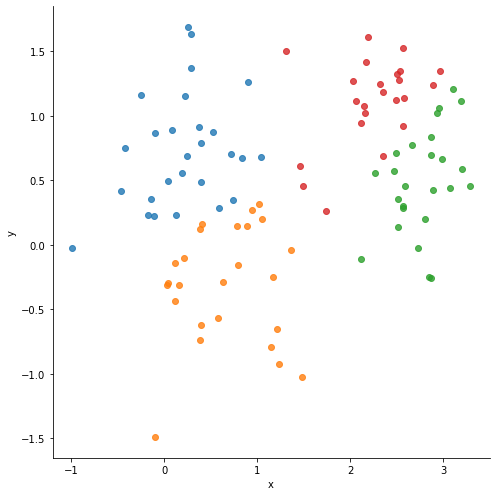

In [ ]:
data = {"x": [], "y": [], "cluster": []}
for i in range(len(assignment_values)):
    data["x"].append(vector_values[i][0])
    data["y"].append(vector_values[i][1])
    data["cluster"].append(assignment_values[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, 
           fit_reg=False, height=7, 
           hue="cluster", legend=False)
plt.show()

예제에서 데이터를 생성할 때 실제로 2개의 군집이 생성되도록 점을 생성했는데 군집을 2개로 세팅해놓고 해당 알고리즘을 실행하면 2개의 군집이 생성된다.
즉, 위의 예제에서 cluster 값을 2로 바꾸고 실행하면 된다.

In [ ]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

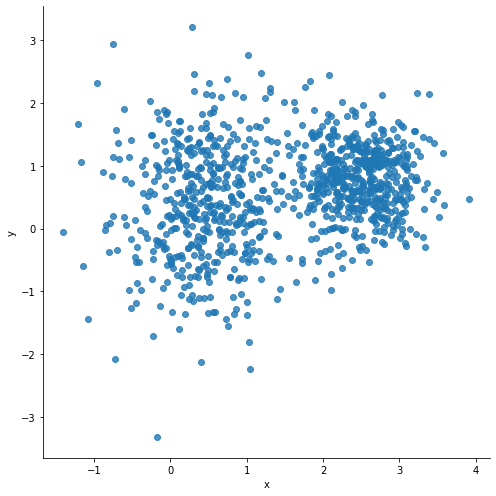

In [ ]:
num_vectors = 1000
num_clusters = 4
num_steps = 100
vector_values = []
for i in range(num_vectors):
  if np.random.random() > 0.5:
    vector_values.append([np.random.normal(0.5, 0.6),
                          np.random.normal(0.3, 0.9)])
  else:
    vector_values.append([np.random.normal(2.5, 0.4),
                         np.random.normal(0.8, 0.5)])

df = pd.DataFrame({"x": [v[0] for v in vector_values], 
                   "y": [v[1] for v in vector_values]})
sns.lmplot("x", "y", data=df, fit_reg=False, height=7)
plt.show()

In [ ]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution ()

In [ ]:
vectors = tf.constant(vector_values)
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], 
        [num_clusters,-1]))
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

print(expanded_vectors.get_shape())
print(expanded_centroids.get_shape())

(1, 1000, 2)
(4, 1, 2)


In [ ]:
distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, 
         expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)
means = tf.concat([
  tf.reduce_mean(
      tf.gather(vectors, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1])
  for c in range(num_clusters)], 0)

update_centroids = tf.assign(centroids, means)

init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

for step in range(num_steps):
   _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments])

In [ ]:
print("centroids")
print(centroid_values)

centroids
[[ 0.11180324 -0.5742624 ]
 [ 1.0162834   0.13184607]
 [ 2.5095446   0.8200467 ]
 [ 0.3365561   1.2393415 ]]


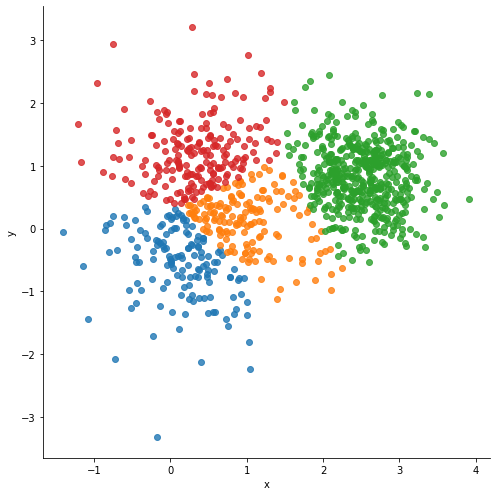

In [ ]:
data = {"x": [], "y": [], "cluster": []}
for i in range(len(assignment_values)):
    data["x"].append(vector_values[i][0])
    data["y"].append(vector_values[i][1])
    data["cluster"].append(assignment_values[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, 
           fit_reg=False, height=7, 
           hue="cluster", legend=False)
plt.show()